<a href="https://colab.research.google.com/github/KevinTheRainmaker/Bio-medical-AI/blob/main/Covid_CT_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid CT Image Classification

## 해결해야 할 문제
### Data Imabalance
의료 데이터는 매우 imbalance한 class 분포를 갖는 경우가 많다. 이 때문에 단순 Accuracy로는 충분한 성능 입증을 하기 어렵다.

> ROC Curve & Precision-Recall Curve / F1 Score 이용

> ![image](https://user-images.githubusercontent.com/76294398/216822915-c64fa67c-d3ef-4386-9889-3eeea8dab9f1.png)

* 참고: Precision은 FP가 적을수록, Recall은 FN이 적을수록 높게 나타난다. 


## Data load & Visualize samples

Original Data Source: https://github.com/UCSD-AI4H/COVID-CT

Related Paper: https://arxiv.org/pdf/2003.13865.pdf

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q /content/drive/MyDrive/data/Covid_Dataset.zip

In [3]:
!ls

Covid_Dataset  drive  __MACOSX	sample_data


In [4]:
root_dir = '/content/Covid_Dataset/'

In [5]:
import random
import os
import cv2
import matplotlib.pyplot as plt

In [6]:
train_path = os.path.join(root_dir, 'Covid_Train')
normal_path = os.path.join(train_path, '0_CT_NonCOVID')
covid_path = os.path.join(train_path, '1_CT_COVID')

normal_files = [os.path.join(normal_path, x) for x in os.listdir(normal_path)]
normal_samples = [cv2.imread(x) for x in random.sample(normal_files, 5)]

covid_files = [os.path.join(covid_path, x) for x in os.listdir(covid_path)]
covid_samples = [cv2.imread(x) for x in random.sample(covid_files, 5)]

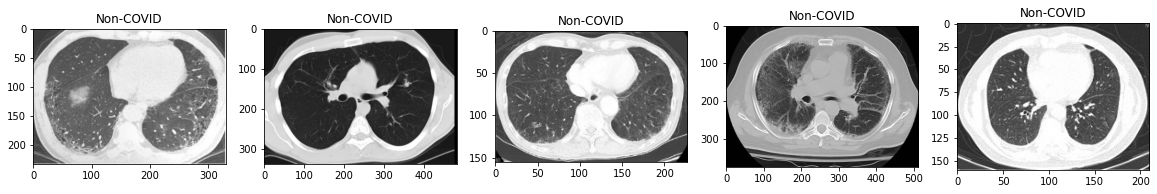

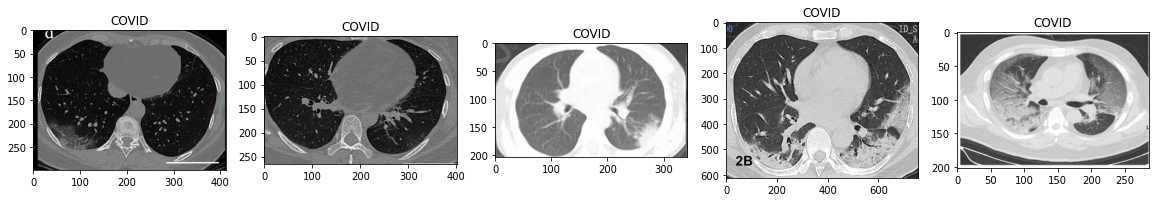

In [7]:
# Non-COVID
plt.figure(figsize=(20,10))
columns = 5

for i, image in enumerate(normal_samples):
  plt.subplot(int(len(normal_samples) / columns+1), columns, i+1)
  plt.title('Non-COVID')
  plt.imshow(image)

# COVID
plt.figure(figsize=(20,10))
columns = 5

for i, image in enumerate(covid_samples):
  plt.subplot(int(len(covid_samples) / columns+1), columns, i+1)
  plt.title('COVID')
  plt.imshow(image)

## EDA

In [8]:
def print_files_in_dir(root_dir, prefix):
  files = os.listdir(root_dir)
  label = ['COVID', 'Non-COVID']
  for i, file in enumerate(files):
    path = os.path.join(root_dir, file)
    file_list = os.listdir(path)
    print(f'{prefix} 데이터의 {label[i]} sample 수: {len(file_list)}')

In [9]:
phase = ['Train','Valid','Test']
print_files_in_dir(root_dir+f'Covid_{phase[0]}', phase[0])
print()
print_files_in_dir(root_dir+f'Covid_{phase[1]}', phase[1])
print()
print_files_in_dir(root_dir+f'Covid_{phase[2]}', phase[2])

Train 데이터의 COVID sample 수: 191
Train 데이터의 Non-COVID sample 수: 234

Valid 데이터의 COVID sample 수: 60
Valid 데이터의 Non-COVID sample 수: 58

Test 데이터의 COVID sample 수: 98
Test 데이터의 Non-COVID sample 수: 105


## Data preprocessing & Build DataLoader

In [10]:
import numpy as np
import torch
import torch.utils.data as data
from torchvision import datasets, transforms

In [11]:
# device setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Current device: {device}')

# set random seed for reproductibility
random_seed = 2023
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Avoid non-deterministic 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Current device: cuda


PyTorch Reproductivity 설정 관련 reference: https://tempdev.tistory.com/28

In [12]:
# Data transform

normalize = transforms.Normalize(mean=[0,0,0], std=[1,1,1])
image_transforms = {
    'train': 
    transforms.Compose([
        transforms.Resize(256),
    
        # data augmentation
        transforms.RandomResizedCrop((224), scale=(0.5,1.0)),
        transforms.RandomHorizontalFlip(),

        transforms.ToTensor(),
        normalize
        ]),

    'valid':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
        ])
}

In [13]:
train_dataset_folder = root_dir + 'Covid_Train'
valid_dataset_folder = root_dir + 'Covid_Valid'
test_dataset_folder = root_dir + 'Covid_Test'

In [14]:
train_dataset = datasets.ImageFolder(root=train_dataset_folder, transform=image_transforms['train'])
valid_dataset = datasets.ImageFolder(root=valid_dataset_folder, transform=image_transforms['valid'])
test_dataset = datasets.ImageFolder(root=test_dataset_folder, transform=image_transforms['valid']) # test_dataset은 valid와 같은 transform 적용

In [15]:
# Parameters for DataLoader

train_params = {
    'batch_size':64,
    'shuffle':True,
    'num_workers':1,
    'drop_last':False
}

valid_params = {
    'batch_size':64,
    'shuffle':False,
    'num_workers':1,
    'drop_last':False
}

DataLoader paramter 용도 reference: https://subinium.github.io/pytorch-dataloader/

In [16]:
train_loader = data.DataLoader(train_dataset, **train_params)
valid_loader = data.DataLoader(valid_dataset, **valid_params)
test_loader = data.DataLoader(test_dataset, **valid_params)

In [17]:
# DataLoader 동작 확인
for x,y in train_loader:
  print(x.shape)
  print(y.shape)
  break

for x,y in valid_loader:
  print(x.shape)
  print(y.shape)
  break

for x,y in test_loader:
  print(x.shape)
  print(y.shape)
  break

torch.Size([64, 3, 224, 224])
torch.Size([64])
torch.Size([64, 3, 224, 224])
torch.Size([64])
torch.Size([64, 3, 224, 224])
torch.Size([64])


## Model

In [18]:
from torchvision import models # 모델을 직접 구현하지 않고도 pre-trained model 사용 가능
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [19]:
# Parameters for Model

cfg = {
    'cls_hid_dims': [1024, 512, 256]
}

In [20]:
# feature extractor
class ResNetExtractor(nn.Module):
  def __init__(self):
    '''
    Args:
      base_model : resnet18 / resnet50
      config : 모델 설정 값
    '''
    super(ResNetExtractor, self).__init__()
    
    model = models.resnet50(pretrained=True)
    num_features = model.fc.in_features
    self.num_features = num_features

    for name, param in model.named_parameters():
      if 'layer2' in name:
        break # layer1만 이용
      param.requires_grad = False # grad 고정 (train 하지 않음)

    self.features = nn.Sequential(*list(model.children())[:-1]) # 마지막 classifier 부분 제외

  def forward(self, x):
    x = self.features(x)
    b = x.size(0)
    x = x.view(b, -1)

    return x


In [21]:
class Classifier(nn.Sequential):
  def __init__(self, features, **config):
    '''
    Args:
      featrues: image embedding model
      config: 모델 설정 값
    '''
    super(Classifier, self).__init__()

    self.features = features
    self.input_dim = features.num_features # image feature size
    self.dropout = nn.Dropout(0.1)
    self.hidden_dims = config['cls_hid_dims'] # classifier hidden dimesions
    layer_size = len(self.hidden_dims) + 1 # hidden layer 개수
    dims = [self.input_dim] + self.hidden_dims + [2]

    self.classifier = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)]) # classifier layer

  def forward(self, x):
    temp = self.features(x)
    for i, l in enumerate(self.classifier):
      if i == (len(self.classifier)-1):
        # last layer
        temp = l(temp)
      else:
        # not last layer: dropout & relu 적용
        temp = F.relu(self.dropout(l(temp)))

    return temp

nn.ModuleList 사용 이유: https://bo-10000.tistory.com/entry/nnModuleList

In [22]:
features = ResNetExtractor()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [23]:
model = Classifier(features, **cfg)
model

Classifier(
  (features): ResNetExtractor(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=Tru

## Model Training

In [24]:
lr = 1e-3
train_epoch = 20

In [25]:
# loss & optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [26]:
import copy
from prettytable import PrettyTable
from time import time
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

In [27]:
loss_history_train = []
loss_history_val = []

max_acc = 0

model = model.to(device)

# Best model initialization
model_best = copy.deepcopy(model)

# 결과 정리 위한 PrettyTable
valid_metric_record = []
valid_metric_header = ['# epoch']
valid_metric_header.extend(['Accuracy','Sensitivity','Specificity','ROC_score'])
table = PrettyTable(valid_metric_header)

float2str = lambda x: '%0.4f'%x # float 소수점 4자리까지 str로 변환

In [32]:
t_start = time()

for e in range(train_epoch):
  # model training
  model.train()
  
  # Mini-batch 학습 
  for i, (v_i, label) in enumerate(train_loader):
      # input data gpu에 올리기 
      v_i = v_i.float().to(device)
      label = label.to(device)
      # forward-pass
      output = model(v_i)  
      # loss
      loss = loss_func(output, label)

      # 각 iter마다 loss 기록
      loss_history_train.append(loss.item())

      # gradient 초기화
      optimizer.zero_grad()

      # backpropagation
      loss.backward()
      optimizer.step()

  # gradient tracing X
  with torch.set_grad_enabled(False):
    y_pred = []
    y_score = []
    y_label = []

    # model validation
    model.eval()

    for i, (v_i, label) in enumerate(valid_loader):
      v_i = v_i.float().to(device)
      label = label.to(device)

      output = model(v_i)
      loss = loss_func(output, label)

      loss_history_val.append(loss)

      pred = output.argmax(dim=1, keepdim=True)
      score = nn.Softmax(dim=1)(output)[:,1]

      # to cpu & to numpy
      pred = pred.cpu().numpy()
      score = score.cpu().numpy()
      label = label.cpu().numpy()

      y_pred = y_pred + pred.flatten().tolist()
      y_score = y_score + score.flatten().tolist()
      y_label = y_label + label.flatten().tolist()
    
  # metric 계산
  classification_metrics = classification_report(y_label, y_pred,
                                                 target_names = ['CT_NonCOVID', 'CT_COVID'],
                                                 output_dict = True,
                                                 zero_division=1
                                                 )
  
  # sensitivity is the recall of the positive class
  sensitivity = classification_metrics['CT_COVID']['recall']

  # specificity is the recall of the negative class 
  specificity = classification_metrics['CT_NonCOVID']['recall']

  # accuracy
  accuracy = classification_metrics['accuracy']

  # confusion matrix
  conf_matrix = confusion_matrix(y_label, y_pred)

  # roc score
  roc_score = roc_auc_score(y_label, y_score)

  # 계산한 metric 합치기
  lst = ["epoch " + str(e)] + list(map(float2str,[accuracy, sensitivity, specificity, roc_score]))

  # 각 epoch 마다 결과값 pretty table에 기록
  table.add_row(lst)
  valid_metric_record.append(lst)
  
  # mse 기준으로 best model 업데이트
  if accuracy > max_acc:
    # best model deepcopy 
    model_best = copy.deepcopy(model)
    # max MSE 업데이트 
    max_acc = accuracy

  # 각 epoch 마다 결과 출력 
  print('Validation at Epoch '+ str(e + 1) + ' , Accuracy: ' + str(accuracy)[:7] + ' , sensitivity: '\
        + str(sensitivity)[:7] + ', specificity: ' + str(f"{specificity}") +' , roc_score: '+str(roc_score)[:7])

Validation at Epoch 1 , Accuracy: 0.70338 , sensitivity: 0.96666, specificity: 0.43103448275862066 , roc_score: 0.89267
Validation at Epoch 2 , Accuracy: 0.78813 , sensitivity: 0.95, specificity: 0.6206896551724138 , roc_score: 0.91321
Validation at Epoch 3 , Accuracy: 0.83898 , sensitivity: 0.93333, specificity: 0.7413793103448276 , roc_score: 0.90057
Validation at Epoch 4 , Accuracy: 0.81355 , sensitivity: 0.91666, specificity: 0.7068965517241379 , roc_score: 0.88132
Validation at Epoch 5 , Accuracy: 0.81355 , sensitivity: 0.8, specificity: 0.8275862068965517 , roc_score: 0.89827
Validation at Epoch 6 , Accuracy: 0.72881 , sensitivity: 0.61666, specificity: 0.8448275862068966 , roc_score: 0.83376
Validation at Epoch 7 , Accuracy: 0.79661 , sensitivity: 0.78333, specificity: 0.8103448275862069 , roc_score: 0.87126
Validation at Epoch 8 , Accuracy: 0.67796 , sensitivity: 0.96666, specificity: 0.3793103448275862 , roc_score: 0.85689
Validation at Epoch 9 , Accuracy: 0.77118 , sensitivit